#### Import Libraries

In [ ]:
import sys
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install xgboost

In [ ]:
pip install lightgbm
pip install xgboost

In [101]:
import pandas as pd
import numpy as np
import pickle
%matplotlib inline

pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#### Processed and External Data

In [2]:
sales = pd.read_csv('train_data_preprocessed.csv')
validation = pd.read_csv('validation_data_preprocessed.csv')
senti_index = pd.read_csv('consumer_sentiment_index.csv')
house_price = pd.read_csv('median_house_price.csv')
inflation_rate = pd.read_csv('inflation_rate_monthly.csv')

In [3]:
## Adding Validation to Train Sales data
sd = sales.sort_values(by=['encoded_sku_id','sales_date'])
vd = validation.sort_values(by=['encoded_sku_id','sales_date'])
vd = vd.drop(columns='forecasted units')
print(sd.shape)
print(vd.shape)

sd = pd.concat([sd,vd], ignore_index= True)
sd = sd.sort_values(by=['encoded_sku_id','sales_date']).reset_index(drop=True)

(879429, 16)
(3773, 16)


In [4]:
## Creating Date derived features
sd['date'] = pd.to_datetime(sd['sales_date'], infer_datetime_format= True)
sd['base_date'] = pd.to_datetime( '2017-05-22',infer_datetime_format= True)
sd['days_diff'] = (sd['date'] - sd['base_date']).dt.days

sd['seq_week'] = sd['days_diff'] // 7
sd['year'] = sd['date'].dt.year
sd['day_of_week'] = sd['date'].dt.dayofweek

sd = sd.drop(columns=["date","base_date",'days_diff'])

##### Imputing negative daily units

In [5]:
"""
Imputing Negative daily units value to mean of the week if weekly units are positive or to 0
"""
weekly_sales = sd.groupby(['encoded_sku_id','seq_week'])['daily_units'].mean()
weekly_sales = weekly_sales.reset_index()
weekly_sales = weekly_sales.rename(columns={"daily_units": "mean_weekly_units"})

sd_ext = (pd.merge(sd,weekly_sales, on=['encoded_sku_id','seq_week']))


daily_sales = []
for i in range(0, len(sd)):
    if sd_ext.loc[i,'daily_units']<0:
        if sd_ext.loc[i,'mean_weekly_units']<0:
            daily_sales.append(0)
        else:
            daily_sales.append(sd_ext.loc[i,'mean_weekly_units'])
    else:
        daily_sales.append(sd_ext.loc[i,'daily_units'])
        

sd_ext['daily_units'] = daily_sales

###### Adding external data variables

In [6]:
## Consumer Sentiment Index
senti_index['year'] = senti_index['date_of_survey'].apply(lambda x: x.split('-')[2]).astype(int)
senti_index['month'] = senti_index['date_of_survey'].apply(lambda x: x.split('-')[1]).astype(int)
senti_index = senti_index[['year','month','csi']]

In [7]:
# Inflation Rate data
inflation_rate = inflation_rate[['year','month','inflation_rate']]

In [ ]:
# Housing Price data
#house_price.head(5)

In [8]:
#Adding Weekly Category Sales data to daily level data
"""
Calculating total category sales(for all SKUs) on weekly level
"""
weekly_category_sales = sd_ext.groupby(['category_name','seq_week'])['daily_units'].sum()
weekly_category_sales = weekly_category_sales.reset_index()
weekly_category_sales = weekly_category_sales.rename(columns={"daily_units": "weekly_cat_sales"})


weekly_class_sales = sd_ext.groupby(['class_name','seq_week'])['daily_units'].sum()
weekly_class_sales = weekly_class_sales.reset_index()
weekly_class_sales = weekly_class_sales.rename(columns={"daily_units": "weekly_class_sales"})


weekly_ml_sales = sd_ext.groupby(['ml_name','seq_week'])['daily_units'].sum()
weekly_ml_sales = weekly_ml_sales.reset_index()
weekly_ml_sales = weekly_ml_sales.rename(columns={"daily_units": "weekly_ml_sales"})


weekly_subclass_sales = sd_ext.groupby(['subclass_name','seq_week'])['daily_units'].sum()
weekly_subclass_sales = weekly_subclass_sales.reset_index()
weekly_subclass_sales = weekly_subclass_sales.rename(columns={"daily_units": "weekly_subclass_sales"})

In [9]:
# Merging to Initial Data

sd_ext = (pd.merge(sd_ext,senti_index, on=['year','month']))
sd_ext = (pd.merge(sd_ext,inflation_rate, on=['year','month']))
sd_ext = (pd.merge(sd_ext,house_price, on=['year','month']))

sd_ext = (pd.merge(sd_ext,weekly_category_sales, on=['category_name','seq_week']))
sd_ext = (pd.merge(sd_ext,weekly_class_sales, on=['class_name','seq_week']))
sd_ext = (pd.merge(sd_ext,weekly_ml_sales, on=['ml_name','seq_week']))
sd_ext = (pd.merge(sd_ext,weekly_subclass_sales, on=['subclass_name','seq_week']))


In [10]:
sd_ext.shape

(883202, 28)

In [11]:
# checking day wise SKU count for validation week
"""
Observation: not all SKUs are present in the validation week.
"""
sd_ext[sd_ext['seq_week']==271]['day_of_week'].value_counts()

0    539
1    539
2    539
3    539
4    539
5    539
6    539
Name: day_of_week, dtype: int64

In [12]:
sd_ext.to_csv('sales_data_with_external.csv',index= False)

#### Aggregation and Feature Engineering

* this step is broken into 2 parts so that we can save the data in intermediate file to not lose information in case of a system crash

##### Part 1

In [14]:
"""
Aggregated Variables
"""
sd_agg = sd_ext.groupby(['encoded_sku_id','seq_week'])

featset1 = sd_agg.agg({'daily_units': ['sum'],
                        'retail_price': ['mean'],
                        'promo_price': ['max'],
                        'competitor_price': ['max']
                        })


"""
conditional Aggregated features
"""
featset1['retail_price_avbl_cnt'] = sd_agg.apply(lambda x: x[x['retail_price'] !=0]['retail_price'].count())

featset1['promo_price_avbl_cnt'] = sd_agg.apply(lambda x: x[x['promo_price_avbl'] ==1 ]['promo_price'].count())
featset1['promo_price_avbl_mean'] = sd_agg.apply(lambda x: x[x['promo_price_avbl']  ==1]['promo_price'].mean())

featset1['competitor_price_avbl_cnt'] = sd_agg.apply(lambda x: x[x['competitor_price_avbl'] ==1 ]['competitor_price'].count())
featset1['competitor_price_avbl_mean'] = sd_agg.apply(lambda x: x[x['competitor_price_avbl']  ==1]['competitor_price'].mean())
featset1['competitor_price_avbl_min'] = sd_agg.apply(lambda x: x[x['competitor_price_avbl']  ==1]['competitor_price'].min())
featset1['competitor_price_avbl_max'] = sd_agg.apply(lambda x: x[x['competitor_price_avbl']  ==1]['competitor_price'].max())



In [15]:
featset1 = featset1.reset_index()
## Writing intermediate files
featset1.to_csv('featset1_data.csv',index=False)

##### Part 2

In [37]:
## Reading intermediate files
featset1 = pd.read_csv('featset1_data.csv')
sd_ext = pd.read_csv('sales_data_with_external.csv')
featset2 = featset1.drop(labels=0, axis=0)

C:\Users\SPECTRE\AppData\Local\Temp\ipykernel_18832\2662809524.py:2: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  featset1 = pd.read_csv('featset1_data.csv')


In [38]:
## Inventory features
"""
Taking count of number of days in a week for each SKU where inventory status was P 
where P is in ('Fully-Stocked','Out-of-Stock','Constrained','Moderate')
"""

new_column = sd_agg.apply(lambda x: x[x['inventory'] =='Fully-Stocked']['inventory'].count())
featset2['inventory_fs_cnt'] = new_column.reset_index()[0]

new_column= sd_agg.apply(lambda x: x[x['inventory'] =='Out-of-Stock']['inventory'].count())
featset2['inventory_oos_cnt'] = new_column.reset_index()[0]

new_column= sd_agg.apply(lambda x: x[x['inventory'] =='Constrained']['inventory'].count())
featset2['inventory_cnstr_cnt'] = new_column.reset_index()[0]

new_column= sd_agg.apply(lambda x: x[x['inventory'] =='Moderate']['inventory'].count())
featset2['inventory_mod_cnt'] = new_column.reset_index()[0]


In [39]:
## External Data Features

"""
Taking mean of external data values for a week for each SKU
"""

new_column = sd_agg.agg({'csi':'mean'})
featset2['mean_weekly_csi'] = new_column.reset_index()['csi']

new_column = sd_agg.agg({'inflation_rate':'mean'})
featset2['mean_weekly_inflation'] = new_column.reset_index()['inflation_rate']

new_column = sd_agg.agg({'Median Home Price (NSA)':'mean'})
featset2['mean_weekly_mh_price'] = new_column.reset_index()['Median Home Price (NSA)']

new_column = sd_agg.agg({'CPI-Adjusted Price':'mean'})
featset2['mean_weekly_cpi_adj_price'] = new_column.reset_index()['CPI-Adjusted Price']


In [40]:
## Category Features
"""
Calculating mean category sales for a week for each SKU
"""

new_column = sd_agg.agg({'weekly_cat_sales':'mean'})
featset2['mean_weekly_cat_sales'] = new_column.reset_index()['weekly_cat_sales']

new_column = sd_agg.agg({'weekly_class_sales':'mean'})
featset2['mean_weekly_class_sales'] = new_column.reset_index()['weekly_class_sales']

new_column = sd_agg.agg({'weekly_subclass_sales':'mean'})
featset2['mean_weekly_subclass_sales'] = new_column.reset_index()['weekly_subclass_sales']

new_column = sd_agg.agg({'weekly_ml_sales':'mean'})
featset2['mean_weekly_ml_sales'] = new_column.reset_index()['weekly_ml_sales']


In [41]:
#Competitor Features
"""
Adding Min and Max competitior price available for each week for each SKU
"""
new_column = sd_agg.apply(lambda x: x[x['competitor_price_avbl'] ==1]['competitor_price'].min())
featset2['competitor_price_avbl_min'] = new_column.reset_index()[0]

new_column = sd_agg.apply(lambda x: x[x['competitor_price_avbl']  ==1]['competitor_price'].max())
featset2['competitor_price_avbl_max'] = new_column.reset_index()[0]

In [44]:
featset2.rename(columns = {'daily_units':'weekly_sales_units',
                           'retail_price':'mean_weekly_retail_price',
                           'promo_price':'max_weekly_promo_price',
                           'competitor_price':'max_weekly_competitor_price'}, inplace = True)

In [45]:
for i in ['weekly_sales_units','mean_weekly_retail_price','max_weekly_promo_price','max_weekly_competitor_price']:
    featset2[i] = featset2[i].astype('float')
    print(f"{i} converted")

weekly_sales_units converted
mean_weekly_retail_price converted
max_weekly_promo_price converted
max_weekly_competitor_price converted


In [47]:
# shift Features
"""
Creating shift variables to capture time series pattern. 
Shift=1 means taking previous week's data
Shift=2 means taking 2 week's previous data
Shift=4 means taking 4 week's previous data

prev_week_{}diff = Difference of metric data with previous week metric data
prev_2week_{}diff = Difference of previous week metric data with 2 week previous metric data
prev_month_{}diff = Difference of metric data with 4 week previous metric data
"""

#Sales Shift
final = featset2.copy()
final['prev_week_sales'] = final['weekly_sales_units'].shift()
final['prev_week_salesdiff'] = final['weekly_sales_units'] - final['prev_week_sales']

final['prev_2week_sales'] = final['weekly_sales_units'].shift(2)
final['prev_2week_salesdiff'] = final['prev_week_sales'] - final['prev_2week_sales']


final['prev_month_sales'] = final['weekly_sales_units'].shift(4)
final['prev_month_salesdiff'] = final['weekly_sales_units'] - final['prev_month_sales']

#Retail Price Shift
final['prev_week_RP'] = final['mean_weekly_retail_price'].shift()
final['prev_week_RPsdiff'] = final['mean_weekly_retail_price'] - final['prev_week_RP']

final['prev_2week_RP'] = final['mean_weekly_retail_price'].shift(2)
final['prev_2week_RPdiff'] = final['prev_week_RP'] - final['prev_2week_RP']


final['prev_month_RP'] = final['mean_weekly_retail_price'].shift(4)
final['prev_month_RPdiff'] = final['mean_weekly_retail_price'] - final['prev_month_RP']

#Inflation Shift
final['prev_week_inflation'] = final['mean_weekly_inflation'].shift()
final['prev_week_inflationdiff'] = final['mean_weekly_inflation'] - final['prev_week_inflation']

final['prev_2week_inflation'] = final['mean_weekly_inflation'].shift(2)
final['prev_2week_inflationdiff'] = final['prev_week_inflation'] - final['prev_2week_inflation']


final['prev_month_inflation'] = final['mean_weekly_inflation'].shift(4)
final['prev_month_inflationdiff'] = final['mean_weekly_inflation'] - final['prev_month_inflation']

#CSI Shift
final['prev_week_csi'] = final['mean_weekly_csi'].shift()
final['prev_week_csidiff'] = final['mean_weekly_csi'] - final['prev_week_csi']

final['prev_2week_csi'] = final['mean_weekly_csi'].shift(2)
final['prev_2week_csidiff'] = final['prev_week_csi'] - final['prev_2week_csi']


final['prev_month_csi'] = final['mean_weekly_csi'].shift(4)
final['prev_month_csidiff'] = final['mean_weekly_csi'] - final['prev_month_csi']

#MH Price Shift
final['prev_week_mh_price'] = final['mean_weekly_mh_price'].shift()
final['prev_week_mh_pricediff'] = final['mean_weekly_mh_price'] - final['prev_week_mh_price']

final['prev_2week_mh_price'] = final['mean_weekly_mh_price'].shift(2)
final['prev_2week_mh_pricediff'] = final['prev_week_mh_price'] - final['prev_2week_mh_price']


final['prev_month_mh_price'] = final['mean_weekly_mh_price'].shift(4)
final['prev_month_mh_pricediff'] = final['mean_weekly_mh_price'] - final['prev_month_mh_price']

#MH Price Shift
final['prev_week_cpi_adj_price'] = final['mean_weekly_cpi_adj_price'].shift()
final['prev_week_cpi_adj_priceediff'] = final['mean_weekly_cpi_adj_price'] - final['prev_week_cpi_adj_price']

final['prev_2week_cpi_adj_price'] = final['mean_weekly_cpi_adj_price'].shift(2)
final['prev_2week_cpi_adj_pricediff'] = final['prev_week_cpi_adj_price'] - final['prev_2week_cpi_adj_price']


final['prev_month_cpi_adj_price'] = final['mean_weekly_cpi_adj_price'].shift(4)
final['prev_month_cpi_adj_pricediff'] = final['mean_weekly_cpi_adj_price'] - final['prev_month_cpi_adj_price']


#Category Sales Shift
final['prev_week_cat_sales'] = final['mean_weekly_cat_sales'].shift()
final['prev_week_cat_salesdiff'] = final['mean_weekly_cat_sales'] - final['prev_week_cat_sales']

final['prev_2week_cat_sales'] = final['mean_weekly_cat_sales'].shift(2)
final['prev_2week_cat_salesdiff'] = final['prev_week_cat_sales'] - final['prev_2week_cat_sales']


final['prev_month_cat_sales'] = final['mean_weekly_cat_sales'].shift(4)
final['prev_month_cat_salesdiff'] = final['mean_weekly_cat_sales'] - final['prev_month_cat_sales']

#ml Sales Shift
final['prev_week_ml_sales'] = final['mean_weekly_ml_sales'].shift()
final['prev_week_ml_salesdiff'] = final['mean_weekly_ml_sales'] - final['prev_week_ml_sales']

final['prev_2week_ml_sales'] = final['mean_weekly_ml_sales'].shift(2)
final['prev_2week_ml_salesdiff'] = final['prev_week_ml_sales'] - final['prev_2week_ml_sales']


final['prev_month_ml_sales'] = final['mean_weekly_ml_sales'].shift(4)
final['prev_month_ml_salesdiff'] = final['mean_weekly_ml_sales'] - final['prev_month_ml_sales']


#class Sales Shift
final['prev_week_class_sales'] = final['mean_weekly_class_sales'].shift()
final['prev_week_class_salesdiff'] = final['mean_weekly_class_sales'] - final['prev_week_class_sales']

final['prev_2week_class_sales'] = final['mean_weekly_class_sales'].shift(2)
final['prev_2week_class_salesdiff'] = final['prev_week_class_sales'] - final['prev_2week_class_sales']


final['prev_month_class_sales'] = final['mean_weekly_class_sales'].shift(4)
final['prev_month_class_salesdiff'] = final['mean_weekly_class_sales'] - final['prev_month_class_sales']

#subclass Sales Shift
final['prev_week_subclass_sales'] = final['mean_weekly_subclass_sales'].shift()
final['prev_week_subclass_salesdiff'] = final['mean_weekly_subclass_sales'] - final['prev_week_subclass_sales']

final['prev_2week_subclass_sales'] = final['mean_weekly_subclass_sales'].shift(2)
final['prev_2week_subclass_salesdiff'] = final['prev_week_subclass_sales'] - final['prev_2week_subclass_sales']


final['prev_month_subclass_sales'] = final['mean_weekly_subclass_sales'].shift(4)
final['prev_month_subclass_salesdiff'] = final['mean_weekly_subclass_sales'] - final['prev_month_subclass_sales']

In [48]:
# Imputing NAN with -999999 so that regressor treats them separately
final = final.fillna(-999999)

In [49]:
## Model Data
final.to_csv('final_data.csv', index=False)

## Model Selection

In [250]:
## RMSE Metric
def rmse(ytrue, ypred):
    return np.sqrt(np.mean((ytrue-ypred)**2))

In [251]:
final = pd.read_csv("final_data.csv")

In [252]:
## checking SKU count for validation week
len(final[final['seq_week']==271])

539

#### Part 1: Model to predict weekly sales unit

#### LGBM regressor

In [253]:
## Setting Search Space
eval_week = 271
lr_list = [0.005,0.0075, 0.01]
est_list = [1000,1250,1500]


In [254]:
# Grid Search Iterations to find best model for weekly sales units prediction

run_time = []
rmse_list = []
pred_list= []
t0 = time.time()
for lr in lr_list:
    print("Starting model fit for lr =%.4f" %lr)
    for est in est_list:
        print("Starting model fit for Estimator =%d" %est)
        t1= time.time()
        train = final[final['seq_week'] < eval_week]
        val = final[final['seq_week'] == eval_week]

        xtr, xts = train.drop(['weekly_sales_units'], axis=1), val.drop(['weekly_sales_units'], axis=1)
        ytr, yts = train['weekly_sales_units'].values, val['weekly_sales_units'].values

        mdl = LGBMRegressor(n_estimators=est, learning_rate=lr, random_state =0)
        mdl.fit(xtr, ytr)

        y_pred_weekly = mdl.predict(xts)

        rmse_error = rmse(yts, y_pred_weekly)
        t2 = round((time.time()-t1)/60,2)
        print('LR = %.4f and Estimator = %d iteration completed in %.2f mins with RMSE: %.5f' % (lr,est,t2,rmse_error))
        run_time.append(t2)
        rmse_list.append(rmse_error)
        pred_list.append(y_pred_weekly)

print("Model Selection completed in",round((time.time()-t0)/60,2),"mins")

lgbm_results = pd.DataFrame(columns=['learning_rate','n_estimators','run_time','rmse','weekly_predictions'])             
lgbm_results['learning_rate'] = np.repeat(lr_list,len(est_list))
lgbm_results['n_estimators'] = est_list*len(lr_list)
lgbm_results['run_time'] = run_time
lgbm_results['rmse'] = rmse_list
lgbm_results['weekly_predictions'] = pred_list

lgbm_results

Starting model fit for lr =0.0050
Starting model fit for Estimator =1000
LR = 0.0050 and Estimator = 1000 iteration completed in 0.69 mins with RMSE: 6.19780
Starting model fit for Estimator =1250
LR = 0.0050 and Estimator = 1250 iteration completed in 0.82 mins with RMSE: 4.92637
Starting model fit for Estimator =1500
LR = 0.0050 and Estimator = 1500 iteration completed in 0.86 mins with RMSE: 4.66259
Starting model fit for lr =0.0075
Starting model fit for Estimator =1000
LR = 0.0075 and Estimator = 1000 iteration completed in 0.57 mins with RMSE: 4.46848
Starting model fit for Estimator =1250
LR = 0.0075 and Estimator = 1250 iteration completed in 0.69 mins with RMSE: 4.19801
Starting model fit for Estimator =1500
LR = 0.0075 and Estimator = 1500 iteration completed in 1.01 mins with RMSE: 4.93078
Starting model fit for lr =0.0100
Starting model fit for Estimator =1000
LR = 0.0100 and Estimator = 1000 iteration completed in 0.63 mins with RMSE: 3.90810
Starting model fit for Estimat

,learning_rate,n_estimators,run_time,rmse,weekly_predictions
0,0.0050,1000,0.69,6.197797,"[6.136498700745433, 17.436458812793063, 5.4253..."
1,0.0050,1250,0.82,4.926375,"[5.728535514198305, 16.7639074090728, 4.974621..."
2,0.0050,1500,0.86,4.662591,"[5.570432462375674, 16.175757458697824, 4.8065..."
3,0.0075,1000,0.57,4.468476,"[5.5706371333128475, 16.196510607942756, 4.844..."
4,0.0075,1250,0.69,4.198006,"[5.447704049140018, 15.862839826329555, 4.7166..."
5,0.0075,1500,1.01,4.930785,"[5.359813605469163, 15.720462872326378, 4.6287..."
6,0.0100,1000,0.63,3.908100,"[5.433350719936108, 15.904329508358312, 4.6319..."
7,0.0100,1250,0.75,4.574581,"[5.275463120220109, 15.640270447435006, 4.4607..."
8,0.0100,1500,0.99,6.418239,"[5.254953197802846, 15.549870967607148, 4.4304..."


#### XGB Regressor

In [ ]:
# Grid Search Iterations to find best model for weekly sales units prediction
run_time = []
rmse_list = []
pred_list= []
t0 = time.time()
for lr in lr_list:
    print("Starting model fit for lr =%.4f" %lr)
    for est in est_list:
        print("Starting model fit for Estimator =%d" %est)
        t1= time.time()
        train = final[final['seq_week'] < eval_week]
        val = final[final['seq_week'] == eval_week]

        xtr, xts = train.drop(['weekly_sales_units'], axis=1), val.drop(['weekly_sales_units'], axis=1)
        ytr, yts = train['weekly_sales_units'].values, val['weekly_sales_units'].values

        mdl = XGBRegressor(n_estimators=est, learning_rate=lr, random_state =0)
        mdl.fit(xtr, ytr)

        y_pred_weekly = mdl.predict(xts)

        rmse_error = rmse(yts, y_pred_weekly)
        t2 = round((time.time()-t1)/60,2)
        print('LR = %.4f and Estimator = %d iteration completed in %.2f mins with RMSE: %.5f' % (lr,est,t2,rmse_error))
        run_time.append(t1)
        rmse_list.append(rmse_error)
        pred_list.append(y_pred_weekly)

print("Model Selection completed in",round((time.time()-t1)/60,2),"mins")
xgb_results = pd.DataFrame(columns=['learning_rate','n_estimators','run_time','rmse','weekly_predictions'])             
xgb_results['learning_rate'] = np.repeat(lr_list,len(est_list))
xgb_results['n_estimators'] = est_list
xgb_results['run_time'] = run_time
xgb_results['rmse'] = rmse_list
xgb_results['weekly_predictions'] = pred_list

xgb_results

In [280]:
eval_week =271
lr = 0.01
est = 1000
t1= time.time()
train = final[final['seq_week'] < eval_week]
val = final[final['seq_week'] == eval_week]

xtr, xts = train.drop(['weekly_sales_units'], axis=1), val.drop(['weekly_sales_units'], axis=1)
ytr, yts = train['weekly_sales_units'].values, val['weekly_sales_units'].values

mdl = XGBRegressor(n_estimators=est, learning_rate=lr, random_state =0)
mdl.fit(xtr, ytr)

print("Model run completed in",round((time.time()-t1)/60,2),"mins")

y_pred = mdl.predict(xts)
error = rmse(yts, y_pred_weekly_champ)
print('Error: %.5f' % (error))

Model run completed in 6.42 mins
Error: 3.90810


XGB Regressor took almost 5 minutes to run an iteration as compared to about 2 minute fo one iteration of LGBM. thus, with no significant performance difference, we decided to move ahead with LGBM as our choice of algorithm.

##### Creating weekly best model

In [255]:
## Creating Weekly Prediction Best Model File
eval_week =271
lr = 0.01
est = 1000

train = final[final['seq_week'] < eval_week]
val = final[final['seq_week'] == eval_week]

xtr, xts = train.drop(['weekly_sales_units'], axis=1), val.drop(['weekly_sales_units'], axis=1)
ytr, yts = train['weekly_sales_units'].values, val['weekly_sales_units'].values

wp_best_mdl = LGBMRegressor(n_estimators=est, learning_rate=lr, random_state =0)
wp_best_mdl.fit(xtr, ytr)

pickle.dump(wp_best_mdl, open('wp_champion_model.pkl', 'wb'))


In [256]:
# Model Error
wp_best_mdl = pickle.load(open('wp_champion_model.pkl', 'rb'))

y_pred_weekly_champ = wp_best_mdl.predict(xts)

error = rmse(yts, y_pred_weekly_champ)
print('Error: %.5f' % (error))

Error: 3.90810


Text(0.5, 0, 'Model Feature Importance')

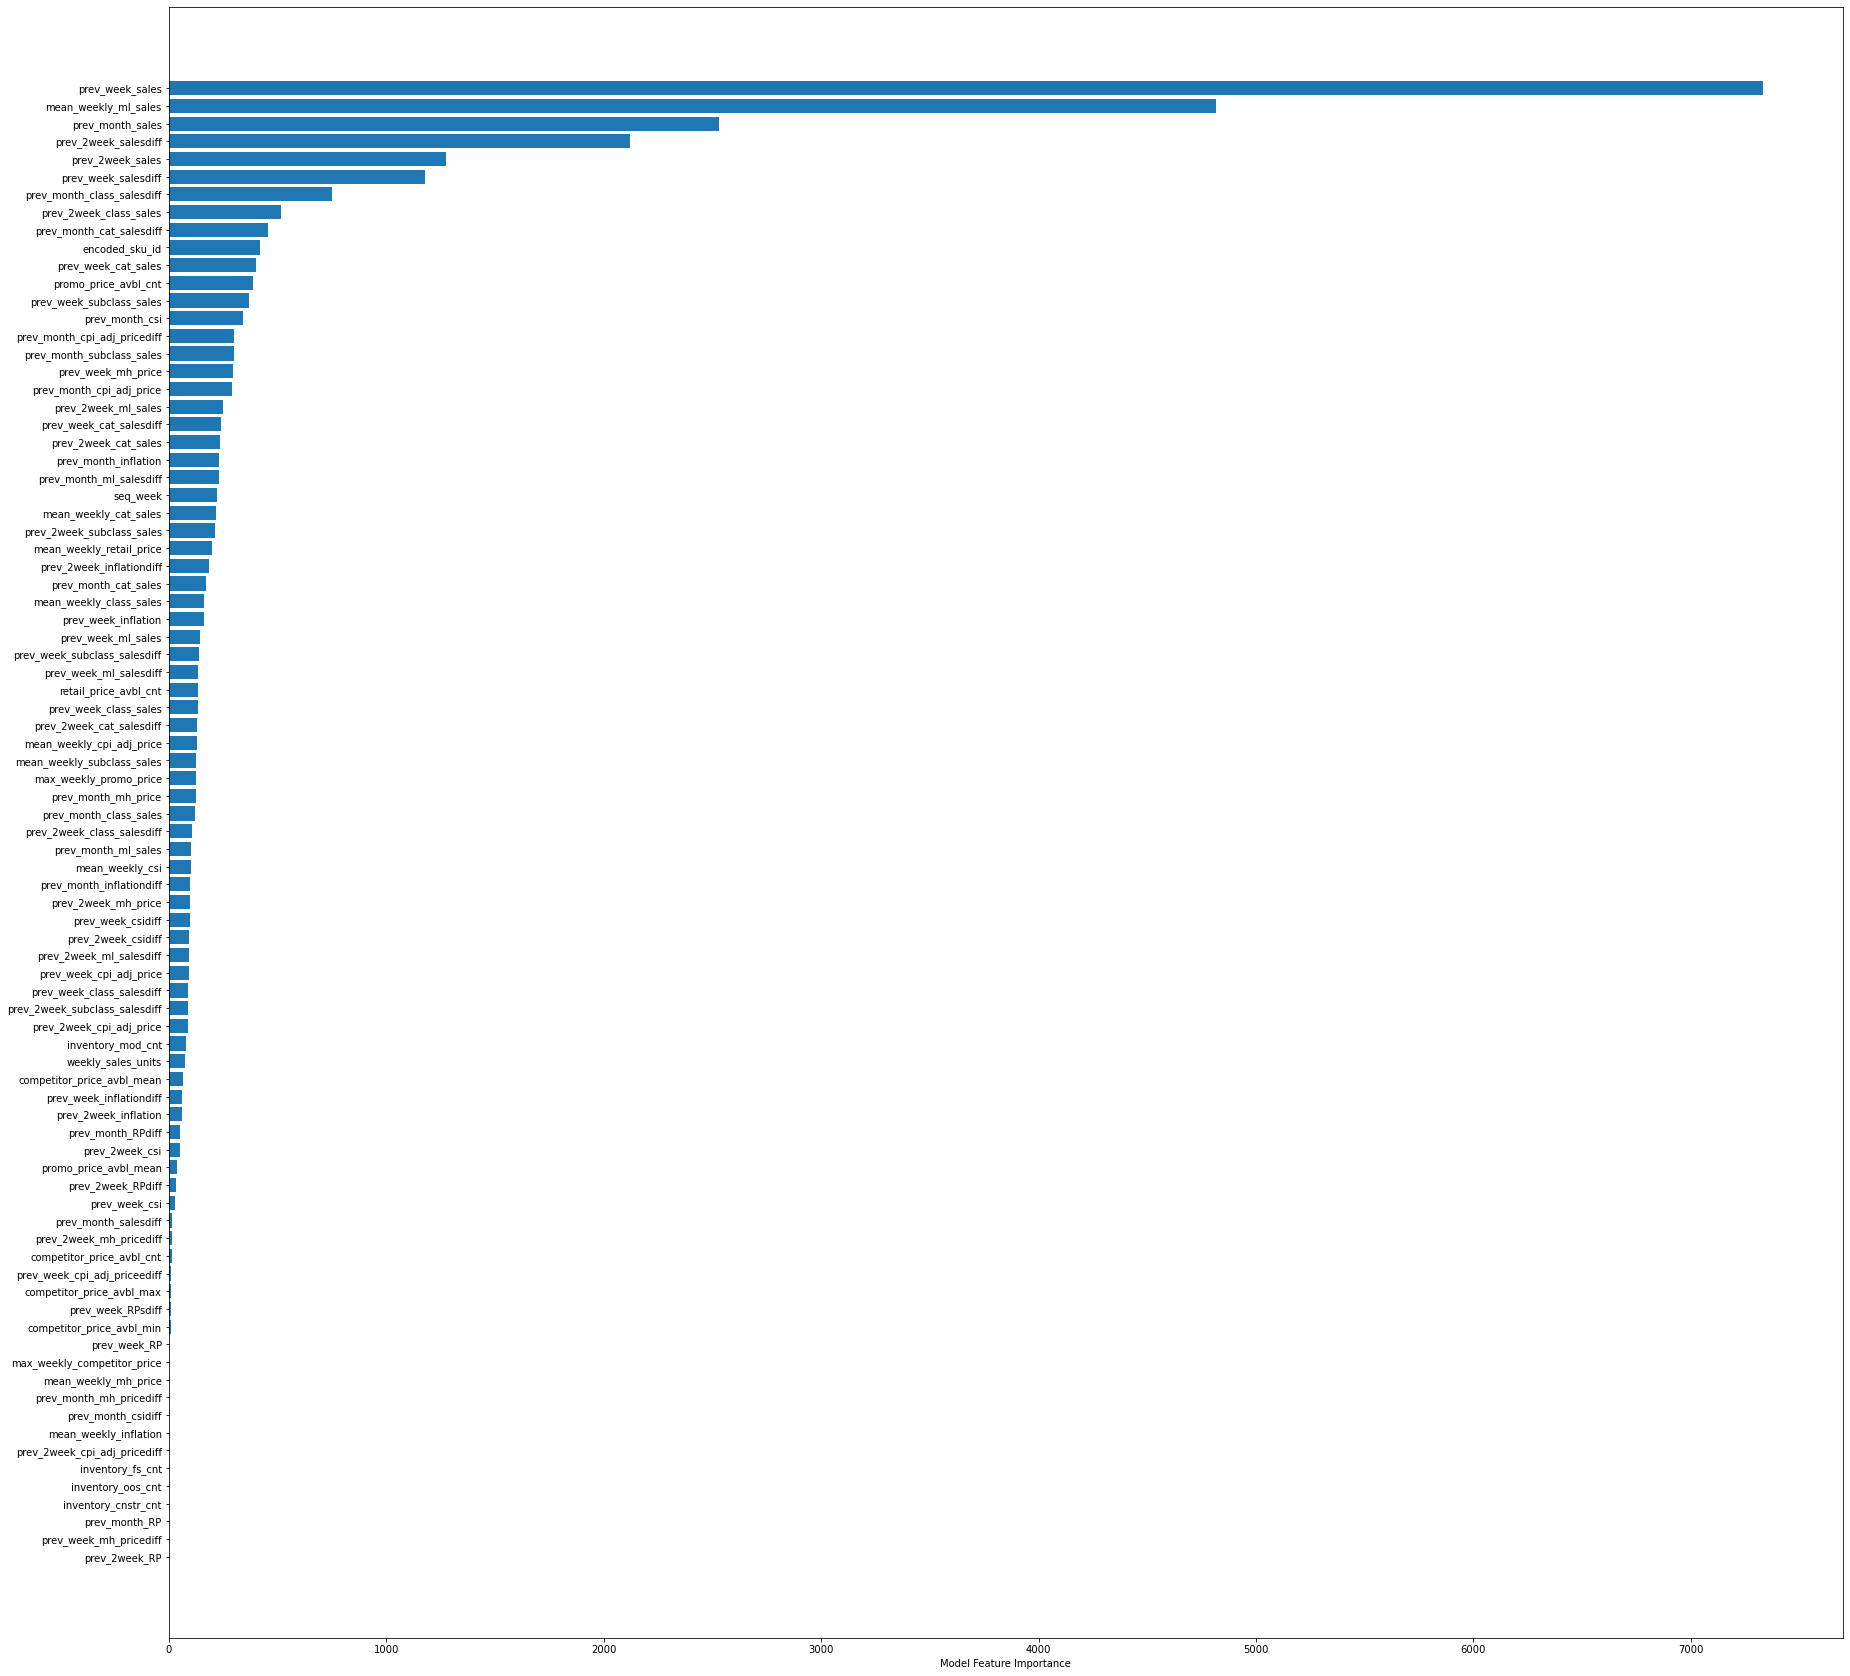

In [257]:
## Plotting Top 20 variables
sorted_idx = wp_best_mdl.feature_importances_.argsort()
plt.figure(figsize=(30,30)) 
plt.barh(val.columns[sorted_idx],wp_best_mdl.feature_importances_[sorted_idx])
plt.xlabel("Model Feature Importance")


#### Part 2: Weekly Proportion strategies

##### Method -1: Ratio of day of week and weekly_daily_units for entire data 

In [258]:
# Transformation
prop_data = sd_ext[sd_ext['seq_week'] < eval_week]

sd_agg_2 = prop_data.groupby(['encoded_sku_id','day_of_week'])

scoring_data = sd_agg_2.agg({'daily_units': ['sum']})
scoring_data = scoring_data.reset_index()
scoring_data.rename(columns = {'daily_units':'dow_sales_units_m1'}, inplace = True)

total_sales = prop_data.groupby(['encoded_sku_id']).agg({'daily_units': ['sum']})
total_sales = total_sales.reset_index()
total_sales = total_sales.loc[total_sales.index.repeat([7])].reset_index(drop=True)

scoring_data['total_sales_m1'] = total_sales['daily_units']
scoring_data.columns = scoring_data.columns.droplevel(1)


scoring_data['percent_sales_m1'] = (scoring_data['dow_sales_units_m1'] / scoring_data['total_sales_m1'])

In [259]:
# Scoring
testset = sd_ext[(sd_ext["seq_week"] == eval_week)]
testset = testset[['encoded_sku_id','seq_week','day_of_week','daily_units']]
testset = testset.sort_values(by=['encoded_sku_id', 'day_of_week'])

testset['weekly_prediction_champion'] =np.repeat(y_pred_weekly_champ,7)
testset = pd.merge(testset,scoring_data, on = ['encoded_sku_id','day_of_week'], how= 'left')

testset['daily_prediction_m1'] = testset['percent_sales_m1']*testset['weekly_prediction_champion']

# RMSE Calculation
a = np.array(testset['daily_prediction_m1'])
b = np.array(testset['daily_units'])

print("RMSE:",rmse(b, a))

RMSE: 2.5076430902659035


##### Method -2: Ratio of day of week and weekly_daily_units for last 12 weeks

In [260]:
# Transformation
prop_data2 = sd_ext[(sd_ext['seq_week'] < eval_week) & (sd_ext['seq_week'] >= eval_week-12)]

sd_agg_3 = prop_data2.groupby(['encoded_sku_id','day_of_week'])

scoring_data2 = sd_agg_3.agg({'daily_units': ['sum']})
scoring_data2 = scoring_data2.reset_index()
scoring_data2.rename(columns = {'daily_units':'dow_sales_units_m2'}, inplace = True)

total_sales2 = prop_data2.groupby(['encoded_sku_id']).agg({'daily_units': ['sum']})
total_sales2 = total_sales2.reset_index()
total_sales2 = total_sales2.loc[total_sales2.index.repeat([7])].reset_index(drop=True)

scoring_data2['total_sales_m2'] = total_sales2['daily_units']
scoring_data2.columns = scoring_data2.columns.droplevel(1)


scoring_data2['percent_sales_m2'] = (scoring_data2['dow_sales_units_m2'] / scoring_data2['total_sales_m2'])

In [261]:
# Scoring
testset = pd.merge(testset,scoring_data2, on = ['encoded_sku_id','day_of_week'], how= 'left')

testset['daily_prediction_m2'] = testset['percent_sales_m2']*testset['weekly_prediction_champion']

testset.columns
# RMSE Calculation
a = np.array(testset['daily_prediction_m2'])
b = np.array(testset['daily_units'])

print("RMSE:",rmse(b, a))

RMSE: 2.237097283058641


##### Method -3: Forecasting the day of week proportion of weekly daily units

In [262]:
featset1 = pd.read_csv('featset1_data.csv')
featset1 = featset1.drop(labels=0, axis=0)

C:\Users\SPECTRE\AppData\Local\Temp\ipykernel_18832\3835679820.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  featset1 = pd.read_csv('featset1_data.csv')


In [264]:
tempset = featset1[['encoded_sku_id','seq_week','daily_units']]
tempset = tempset.rename(columns={"daily_units": "weekly_units"})

In [265]:
#Transformation of daily level data
featset5 = sd_ext.sort_values(by=['encoded_sku_id','sales_date']).merge(tempset, how='inner', on=['encoded_sku_id','seq_week'])
featset5['weekly_units'] = featset5['weekly_units'].astype('float')
featset5['daily_proportion'] = featset5['daily_units'] / featset5['weekly_units']
featset5['daily_proportion'] = featset5['daily_proportion'].fillna(0)

In [266]:
#Quality Check
"""
Number of output rows should be 0
"""
featset5[featset5['daily_proportion'] >1 ]

,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,promo_price_avbl,competitor_price_avbl,month,week,day,seq_week,year,day_of_week,mean_weekly_units,csi,inflation_rate,Median Home Price (NSA),CPI-Adjusted Price,weekly_cat_sales,weekly_class_sales,weekly_ml_sales,weekly_subclass_sales,weekly_units,daily_proportion


In [267]:
#One hot encoding of categorical variables
featset5 = featset5.drop('subclass_name',axis = 1)
featset5 = featset5.drop('day',axis = 1)
featset5 = featset5.drop('sales_date',axis = 1)

one_hot = pd.get_dummies(featset5['class_name'])
# Drop column B as it is now encoded
featset5 = featset5.drop('class_name',axis = 1)
# Join the encoded df
featset5 = featset5.join(one_hot)

one_hot = pd.get_dummies(featset5['ml_name'])
# Drop column B as it is now encoded
featset5 = featset5.drop('ml_name',axis = 1)
# Join the encoded df
featset5 = featset5.join(one_hot)

one_hot = pd.get_dummies(featset5['category_name'])
# Drop column B as it is now encoded
featset5 = featset5.drop('category_name',axis = 1)
# Join the encoded df
featset5 = featset5.join(one_hot)

one_hot = pd.get_dummies(featset5['inventory'])
# Drop column B as it is now encoded
featset5 = featset5.drop('inventory',axis = 1)
# Join the encoded df
featset5 = featset5.join(one_hot)

In [ ]:
featset5 = featset5.drop(columns = ['daily_units'])

In [268]:
## Setting Search Space
eval_week = 271
lr_list = [0.01, 0.0125]
est_list = [800,900,1000]


In [ ]:
# Grid Search Iterations to find best model for day of week proportion prediction
run_time = []
rmse_list = []
pred_list= []
t0 = time.time()
for lr in lr_list:
    print("Starting model fit for lr =%.4f" %lr)
    for est in est_list:
        print("Starting model fit for Estimator =%d" %est)
        t1= time.time()
        train_prop = featset5[featset5['seq_week'] < eval_week]
        val_prop = featset5[featset5['seq_week'] == eval_week]

        xtr_prop, xts_prop = train_prop.drop(['daily_proportion'], axis=1), val_prop.drop(['daily_proportion'], axis=1)
        ytr_prop, yts_prop = train_prop['daily_proportion'].values, val_prop['daily_proportion'].values

        mdl = LGBMRegressor(n_estimators=est, learning_rate=lr, random_state =0)
        mdl.fit(xtr_prop, ytr_prop)

        y_pred_prop = mdl.predict(xts_prop)

        rmse_error = rmse(yts_prop, y_pred_prop)
        t2 = round((time.time()-t1)/60,2)
        print('LR = %.4f and Estimator = %d iteration completed in %.2f mins with RMSE: %.5f' % (lr,est,t2,rmse_error))
        run_time.append(t2)
        rmse_list.append(rmse_error)
        pred_list.append(y_pred_prop)

print("Model Selection completed in",round((time.time()-t0)/60,2),"mins")

lgbm_prop_results = pd.DataFrame(columns=['learning_rate','n_estimators','run_time','rmse','weekly_predictions'])             
lgbm_prop_results['learning_rate'] = np.repeat(lr_list,len(est_list))
lgbm_prop_results['n_estimators'] = est_list*len(lr_list)
lgbm_prop_results['run_time'] = run_time
lgbm_prop_results['rmse'] = rmse_list
lgbm_prop_results['weekly_predictions'] = pred_list

lgbm_prop_results

In [ ]:
best = lgbm_prop_results.sort_values(by=['rmse'], ascending=True)
best.iloc[0]

In [271]:
## Creating Weekly proportion Prediction Best Model File
"""
enter the parameter value from best
"""
eval_week =271
lr = 0.0125
est = 1000

train_prop = featset5[featset5['seq_week'] < eval_week]
val_prop = featset5[featset5['seq_week'] == eval_week]
t1= time.time()
xtr_prop, xts_prop = train_prop.drop(['daily_proportion'], axis=1), val_prop.drop(['daily_proportion'], axis=1)
ytr_prop, yts_prop = train_prop['daily_proportion'].values, val_prop['daily_proportion'].values

pp_best_mdl = LGBMRegressor(n_estimators=est, learning_rate=lr, random_state =0)
pp_best_mdl.fit(xtr_prop, ytr_prop)
print("Time taken %.2f min" % ((time.time()-t1)/60))

pickle.dump(pp_best_mdl, open('pp_champion_model.pkl', 'wb'))


Time taken 2.17 min


In [ ]:
# Proportion Prediction and Evaluation
pp_best_mdl = pickle.load(open('pp_champion_model.pkl', 'rb'))

y_pred_prop_champ = pp_best_mdl.predict(xts_prop)

error = rmse(yts_prop, y_pred_prop_champ)
print('Error: %.5f' % (error))

##### Daily Units Prediction and scoring

In [ ]:
testset['percent_sales_m3'] =y_pred_prop_champ

testset['daily_prediction_m3'] = testset['percent_sales_m3']*testset['weekly_prediction_champion']


# RMSE Calculation
a = np.array(testset['daily_prediction_m3'])
b = np.array(testset['daily_units'])

rmse(b, a)

In [ ]:
sum_check = testset.groupby('encoded_sku_id')['percent_sales_m3'].sum()
sum_check = sum_check.reset_index()
sum_check

In [ ]:
## Quality Check
sum_check[sum_check['percent_sales_m3']>1.05]

In [ ]:
## QC check
sum_check[sum_check['percent_sales_m3']<0.95]

In [279]:
testset.to_csv('validation_results.csv')